# Robotic Localization

In robotics, localization is the problem of finding a robots location in a known environment.   Here we will consider the localization problem from a Bayesian perspective.  We assume we have a "map" of the environment and will construct a probability density over the robots location.

In more general settings, a description of the environment may not be available and the robot needs to simultaneously estimate its location as well as map the environment it's in.   This is called Simultaneous Localization and Mapping (SLAM) and is an important and interesting problem, but is outside the scope of this class.   If you are interested in learning more about these types of problems, there is a great book, [Probabilistic Robotics](http://www.probabilistic-robotics.org/) that goes into much more detail.

Assume our robot is dropped into a short hallway with a few alcoves on one side.  Assume we know the length of the hallway and the width of the hallway, including any alcoves, at any point.  Here's an illustration of what our made up hallway might look like:

![Image](RobotMap.png)

Let $(x_0,y_0)$ denote the initial (unknown) position of the robot and let $w(x)$ denote the width of the hallway at any horizontal position $x$.

We will assume that the robot can only "sense" its surroundings with a single rangefinder pointing in the positive $y$ direction (i.e., upwards in the image above).  This rangefinder returns a distance $d$ between the robot and the alcoved wall.  We will try to incorporating many different observations of this distance as the robot moves horizontally in the positive $x$ direction (i.e., to the right).

### Bayesian Formulation

Recall that the likelihood function in Bayes' rule is a statistical model for what we expect the data to look like given fixed values of our parameters.   Here, our data will be observations of the distance between the robot and upper wall (labeled $d$ in the figure above).   Of course, in the real world we probably wouldn't be able to measure the distance exactly.  Sonar- or laser-based rangefinders aren't perfect and there might be a small amount of error or "noise" in the observations.   Here we model that noise by assuming the observed distance is the true distance plus some additive noise denoted by $\epsilon$.  More specifically, let $d_i$ denote the $i^{th}$ observed distance at a horizontal location $x_0+h_i$ (i.e., the value returned by the rangefinder) and let $d(x_0+h_i)$ denote the true distance between the robot and upper wall.  With these definitions, we model the relationship between the true distance $d(x_0 + h_i)$ and the observed distance $d_i$ using

$$
d_i = d(x_0 + h_i) + \epsilon_i.
$$

Of course we don't know the exact value of the noise $\epsilon_i$; if we did, then we would know the exact distance to the wall.   Since we're working in a Bayesian setting, we will account for our uncertainty in the value of $\epsilon_i$ by treating it as a random varible.  In particular, we assume that the noise can be modeled as a Normal random variable with zero mean and variance $\sigma_\epsilon$.   This is a common assumption for reasons that we will dig into later in the course.  With this Normal assumption, the density of $\epsilon_i$ is given by

$$
\begin{eqnarray}
f(\epsilon_i) &=& N(0, \sigma^2)\\
& = & \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[-\frac{1}{2}\frac{\epsilon^2}{\sigma^2} \right].
\end{eqnarray}
$$

Because $\epsilon_i = d_i - d(x_0+h_i)$, the likelihood function $f(d_i | x_0, y_0)$ is given by substituting this relationship into $f(\epsilon_i)$ above, yielding

$$
f(d_i | x_0, y_0) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left[-\frac{1}{2}\frac{\left(d_i - d(x_0+h_i)\right)^2}{\sigma^2} \right].
$$


For the prior density, we assume that we know nothing about the initial location of the robot and that all locations in the hallway are equally likely.  This can be expressed with a uniform density over all locations

$$
f(x_0,y_0) \propto 1.
$$

In this definition of the prior, we have ignored any normalization constants.   To simplify implemenation in this example, we will be working entirely with "unnormalized densities", which are functions that are proportional to probability density functions, but do not integrate to $1$ as required for a proper probability density.    Unnormalized densities are computationally convenient and sufficient for visualization, but without normalization cannot be used to compute event probabilities.   


Combining the likelihood and prior, we have 

$$
\begin{eqnarray}
f(x_0, y_0 | d_1) &\propto& f(d_1 | x_0, y_0) f(x_0,y_0)\\
& \propto & f(d_1 | x_0, y_0), 
\end{eqnarray}
$$

and assuming subsequent observations are conditionally independent, we have the posterior given $N$ observations

$$
f(x_0, y_0 | d_1, d_2, \ldots, d_N)  \propto  \prod_{i=1}^N f(d_i | x_0,y_0).
$$


### Implementation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
hallway_width = 0.55
hallway_length = 10.0

true_pos = (0.5, 0.4)

Nx = 200
Ny = 100

In [3]:
def FormatPlots():
    plt.xlim([-0.2,hallway_length+0.2])
    plt.ylim([-0.1, hallway_width+0.3])

    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$x_2$', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.show()

In [4]:
def UpperFunction(x):
    
    output = hallway_width
    
    if(x<0):
        return 0.0
    if(x>hallway_length):
        return 0.0
    
    bumps = [ [1.5,2.5], [4.5,6.0], [6.5,7.5]]
    for bump in bumps:
        if((x>bump[0])&(x<bump[1])):
            output += 0.2
    
    return output

In [5]:
xs = np.linspace(-0.1,hallway_length+0.1, Nx)

upper = np.zeros(Nx)
bottom = np.zeros(Nx)
for i in range(Nx):
    upper[i] = UpperFunction(xs[i])


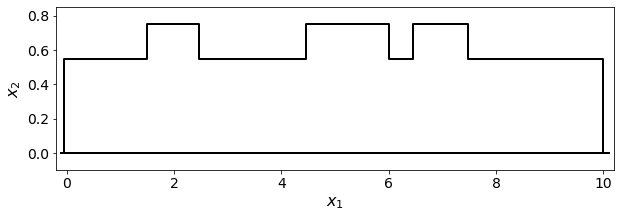

In [6]:
plt.figure(figsize=(10,3))

plt.step(xs, upper, '-k', linewidth=2)
plt.step(xs, bottom, '-k', linewidth=2)

FormatPlots()

In [7]:
ys = np.linspace(0,hallway_width+0.2, Ny)
X, Y = np.meshgrid(xs,ys)

In [8]:
def Prior(X,Y):
    
    priorDens = np.zeros(X.shape)
    for col in range(X.shape[1]):
        priorDens[Y[:,col]<upper[col],col] = 1.0
        priorDens[Y[:,col]<0.001, col] = 0.0
        
    return priorDens

In [9]:
prior = Prior(X,Y)

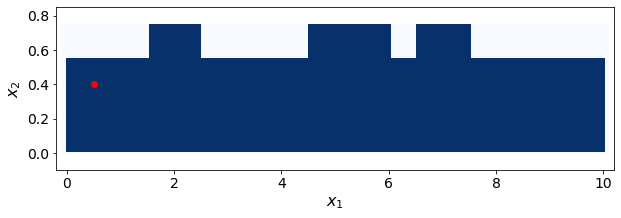

In [10]:
plt.figure(figsize=(10,3))
plt.pcolormesh(xs, ys, prior, cmap='Blues')

plt.plot(true_pos[0],true_pos[1], 'or')

FormatPlots()

In [11]:
def SonarLikelihood(X0, Y0, horz_shift, dist_to_upper):
    """
    ARGS:
        X0 (np.array): A 2D matrix of possible horizontal starting locations
        Y0 (np.array): A 2D matrix of possible vertical starting positions (should be the same shape as X0)
        horz_shift: How far the robot has moved horizontally from its initial position\
        dist_to_upper: A noisy observation of the distance to the upper wall at the point (X0+horz_shift, Y0)
        
    RETURNS:
        np.array: A 2D matrix of the likelihood function (up to a normalizing constant)
        
    """
    
    obs_var = 0.01
    likely = np.zeros(X0.shape)
    for i in range(X0.shape[0]):
        for j in range(X0.shape[1]):
            likely[i,j] = np.exp(-(0.5/obs_var)*(UpperFunction(X0[i,j]+horz_shift)-Y[i,j]-dist_to_upper)**2)
            
    return likely
    
likely = SonarLikelihood(X,Y, 0.0, UpperFunction(true_pos[0])-true_pos[1])

post = likely*prior

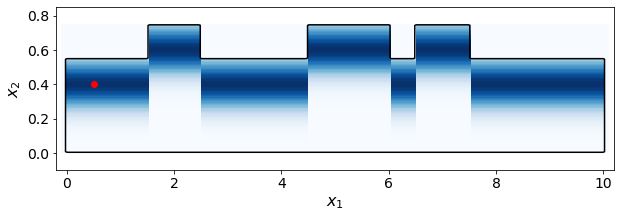

In [12]:
plt.figure(figsize=(10,3))

plt.pcolormesh(xs,ys,post, cmap='Blues')
plt.contour(xs,ys,prior,levels=[0.5], colors='k')

plt.plot(true_pos[0],true_pos[1], 'or')

FormatPlots()

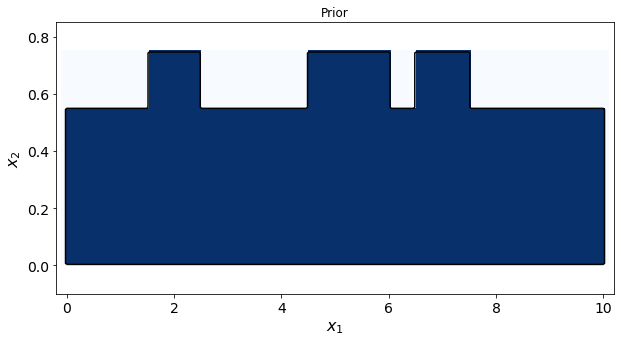

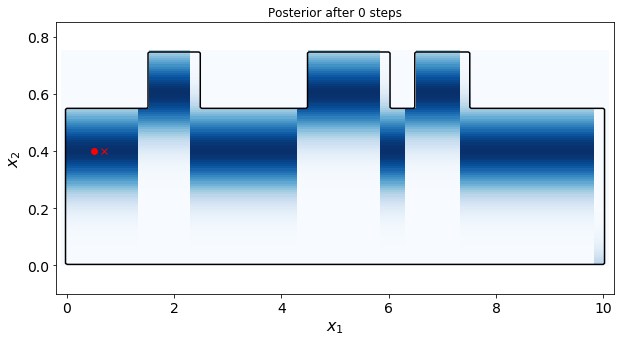

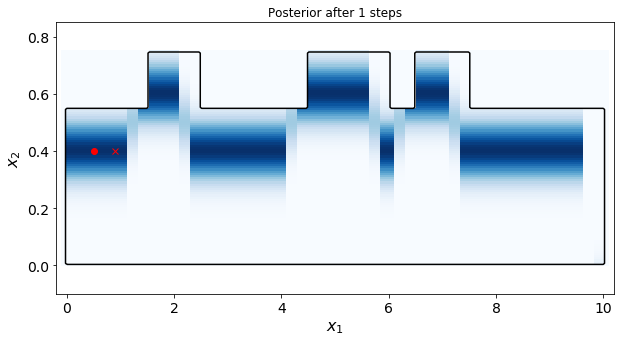

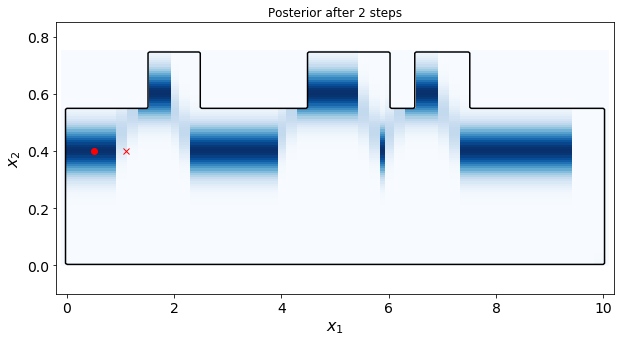

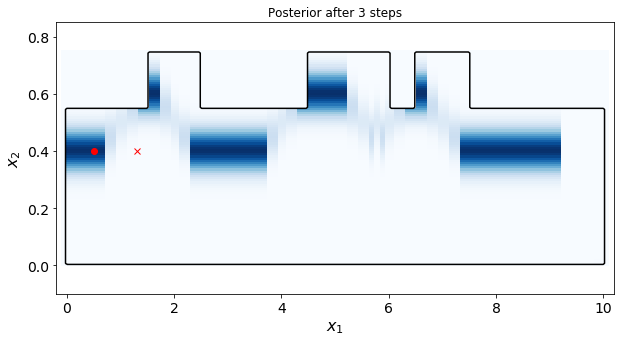

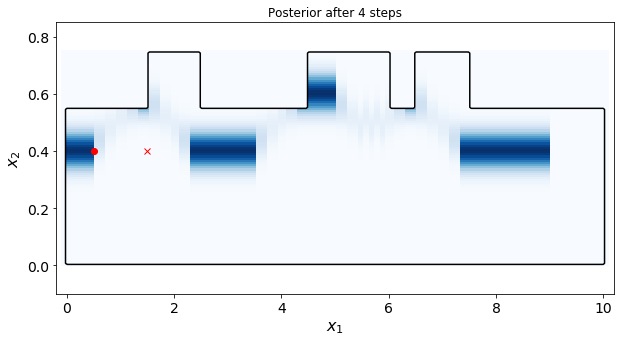

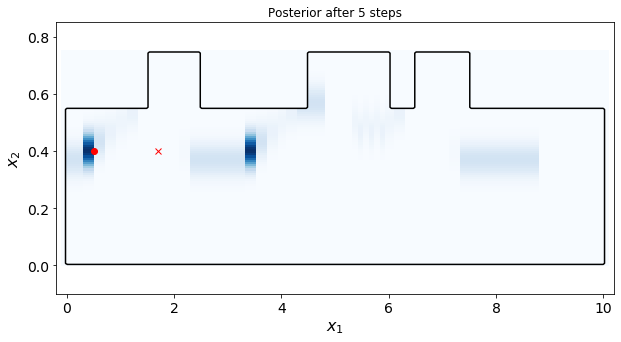

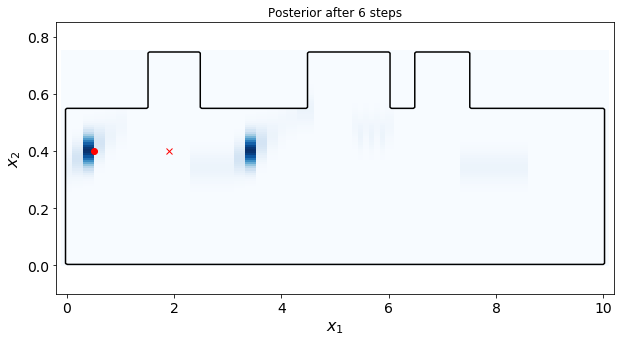

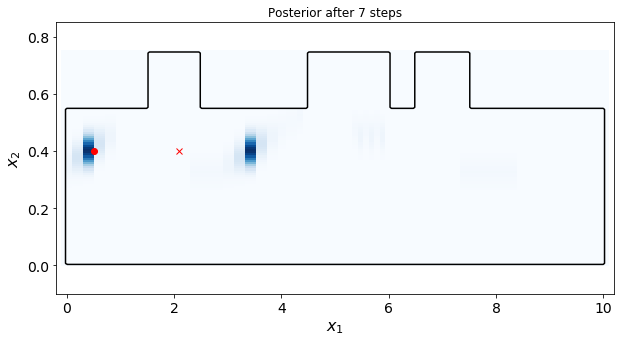

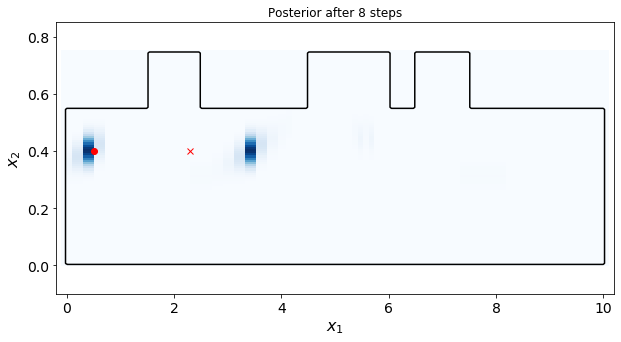

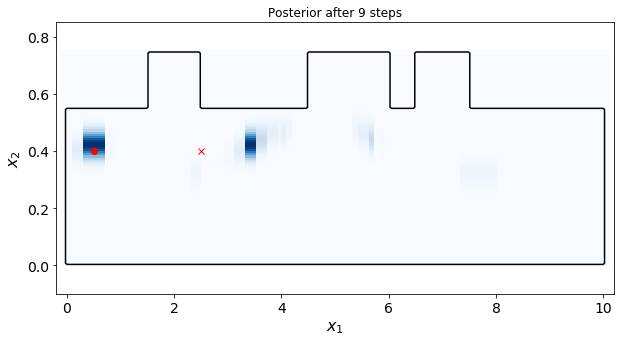

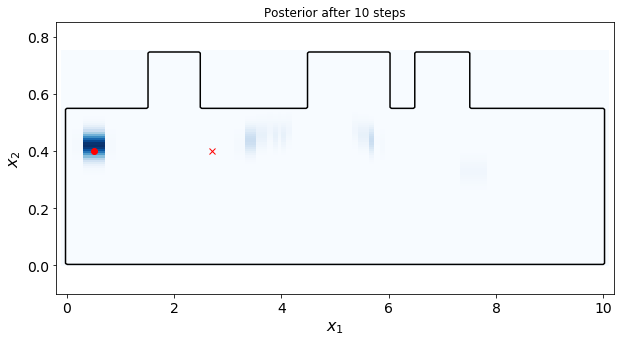

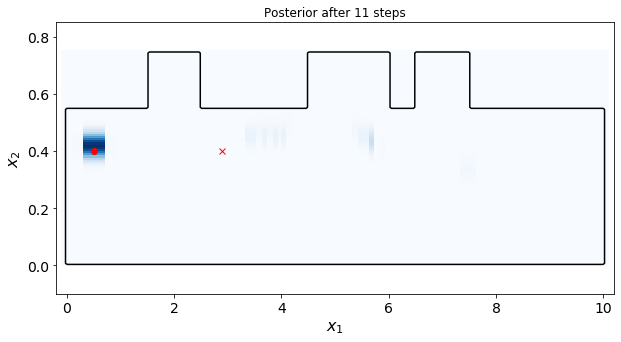

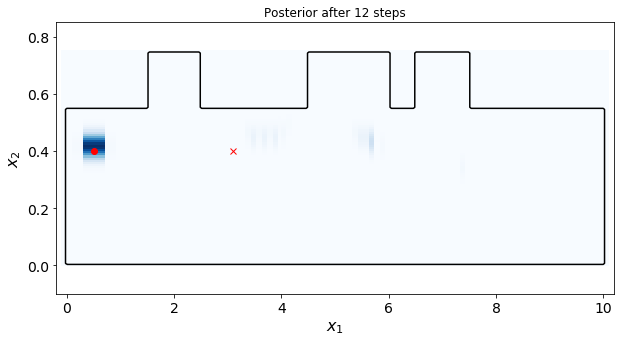

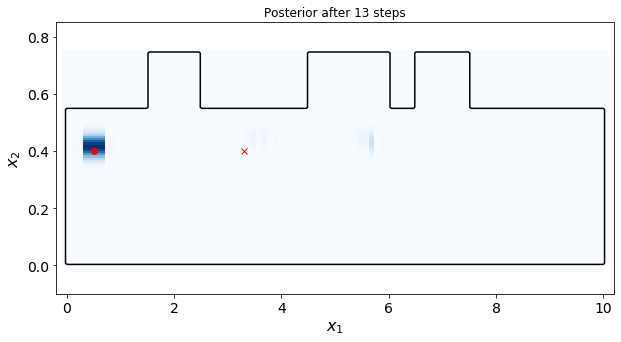

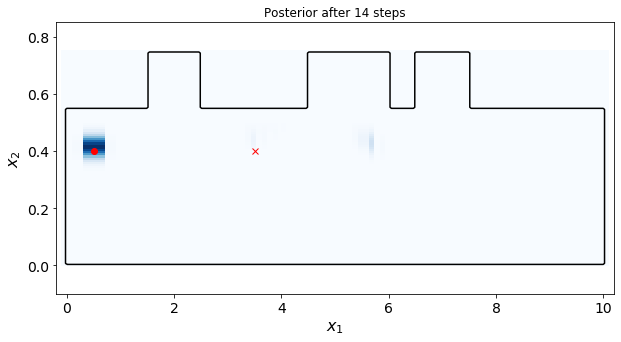

In [13]:
horz_shift = 0.0
step_size = 0.2

post = np.copy(prior)
plt.figure(figsize=(10,5))
plt.pcolormesh(xs,ys,prior, cmap='Blues')
plt.contour(xs,ys,prior,levels=[0.5], colors='k')
    
plt.title('Prior')
FormatPlots()


for i in range(15):
    horz_shift += step_size
    
    likely = SonarLikelihood(X, Y, horz_shift, UpperFunction(true_pos[0]+horz_shift)-true_pos[1])
    post = post*likely
    
    plt.figure(figsize=(10,5))
    plt.pcolormesh(xs,ys,post, cmap='Blues')
    plt.contour(xs,ys,prior,levels=[0.5], colors='k')
    
    plt.plot(true_pos[0],true_pos[1], 'or')
    plt.plot(true_pos[0]+horz_shift,true_pos[1], 'xr')
    plt.title('Posterior after %i steps'%i)
    
    FormatPlots()

plt.show()